# Data Gathering
1. The dataset used for this assessment was obtained from https://ph.investing.com/equities/sm-prime-hldgs-historical-data
2. The date in the given dataset ranges from 2020/10/07 to 2022/10/19 (yyyy/mm/dd)
3. The dataset is manually edited to add future dates: 2022/10/08 to 2022/10/19

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [2]:
# Set random seed to get the same result after each time running the code
tf.random.set_seed(1234)

# Data Preparation
1. Inverting the dataset and reshaping it

In [3]:
file = 'SMPH.csv'
sm = pd.read_csv(file, parse_dates = ['Date'], index_col = 'Date')
sm=sm.iloc[::-1]
sm.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-10-07,29.30,29.60,29.60,28.90,7.29M,-1.01%
2020-10-08,29.75,29.60,29.80,28.75,3.33M,1.54%
2020-10-09,29.10,29.60,29.60,28.80,7.03M,-2.18%
2020-10-12,30.00,29.10,30.00,28.95,4.61M,3.09%
2020-10-13,29.95,29.95,30.15,29.50,3.52M,-0.17%


In [4]:
# Split train data and test data

train_size = int(len(sm)*0.8)

# Do not forget use iloc to select a number of rows
training_set = sm.iloc[:train_size, 1:2].values
test_set = sm.iloc[train_size:, 1:2].values

In [5]:
# Scale data
# The input to scaler.fit -> array-like, sparse matrix, dataframe of shape (n_samples, n_features)
sc = MinMaxScaler(feature_range = (0, 1))
scaler = MinMaxScaler().fit(training_set)
training_set_scaled = sc.fit_transform(training_set)

In [6]:
train_scaled = scaler.transform(training_set)
test_scaled = scaler.transform(test_set)

In [7]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 8):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)

In [8]:
X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

In [9]:
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (374, 30, 1)
y_train.shape:  (374, 1)
X_test.shape:  (71, 30, 1)
y_test.shape:  (71, 1)


In [10]:
X_test[:33].shape

(33, 30, 1)

# Choosing Model
1. The chosen model for this assessment is BiLSTM

In [11]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
    input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

In [12]:
model_bilstm = create_bilstm(64)

# Data Training
1. The data that will be trained in this section will be used for data evaluation

In [13]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
    patience = 10)
    history = model.fit(X_train, y_train, epochs = 200, validation_split = 0.2,
    batch_size = 16, shuffle = False)
    return history

In [14]:
history_bilstm = fit_model(model_bilstm)

Epoch 1/200
19/19 [==============================] - 21s 275ms/step - loss: 0.0840 - val_loss: 0.0536
Epoch 2/200
19/19 [==============================] - 1s 58ms/step - loss: 0.0235 - val_loss: 0.0239
Epoch 3/200
19/19 [==============================] - 1s 58ms/step - loss: 0.0140 - val_loss: 0.0172
Epoch 4/200
19/19 [==============================] - 1s 57ms/step - loss: 0.0116 - val_loss: 0.0174
Epoch 5/200
19/19 [==============================] - 1s 57ms/step - loss: 0.0111 - val_loss: 0.0176
Epoch 6/200
19/19 [==============================] - 1s 56ms/step - loss: 0.0106 - val_loss: 0.0178
Epoch 7/200
19/19 [==============================] - 1s 55ms/step - loss: 0.0103 - val_loss: 0.0190
Epoch 8/200
19/19 [==============================] - 1s 56ms/step - loss: 0.0105 - val_loss: 0.0210
Epoch 9/200
19/19 [==============================] - 1s 56ms/step - loss: 0.0108 - val_loss: 0.0224
Epoch 10/200
19/19 [==============================] - 1s 55ms/step - loss: 0.0108 - val_loss: 0.02

# Data Evaluation
1. The trained data will be evaluated in this section

In [15]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

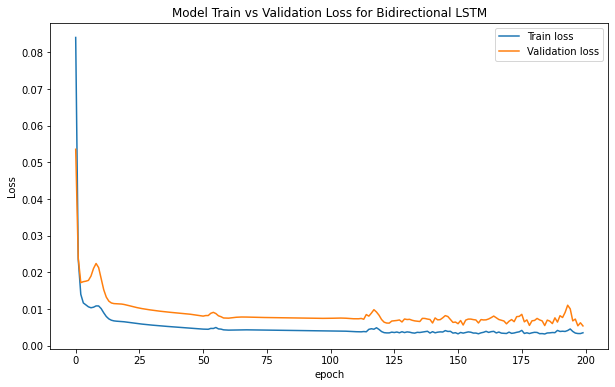

In [16]:
plot_loss (history_bilstm, 'Bidirectional LSTM')

In [17]:
# Transform data back to original data space
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [18]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

In [19]:
prediction_bilstm = prediction(model_bilstm)

In [20]:
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Price')

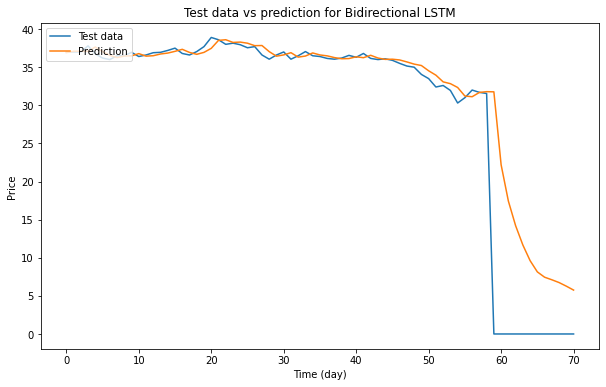

In [21]:
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

In [22]:
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

In [23]:
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

Bidirectiona LSTM:
Mean Absolute Error: 2.4928
Root Mean Square Error: 5.9939



# Data Prediction
1. This section will present the forecasted price for the stock market of SMPH

In [24]:
# Select 60 days of data from test data
new_data = test_set[0:42]
# Scale the input
scaled_data = scaler.transform(new_data)

In [25]:
# Reshape the input 
def create_dataset (X, look_back = 1):
    Xs = []
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
    return np.array(Xs)

In [26]:
X_30= create_dataset(scaled_data,30)
print('X_30.shape: ', X_30.shape) 

X_30.shape:  (12, 30, 1)


In [27]:
# Make prediction for new data
def prediction(model):
    prediction = model.predict(X_30)
    prediction = scaler.inverse_transform(prediction)
    return prediction

In [28]:
prediction_bilstm = prediction(model_bilstm)

In [29]:
# Plot history and future
def plot_multi_step(history, prediction1):
    plt.figure(figsize=(15, 6))
    global range_history, range_future
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))
    global data , a , b
    data=sm.filter(['Price'])
    a=plt.plot(np.arange(range_history), np.array(history), color = 'green', label='History')
    b=plt.plot(range_future, np.array(prediction1), color = 'red', label='Forecasted Price')
    plt.legend(loc='upper right')
    plt.xlabel('Day')
    plt.ylabel('Price Forecast')

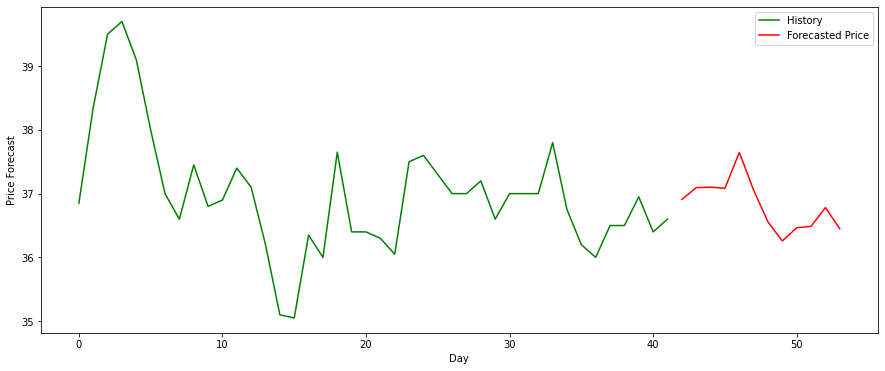

In [30]:
plot_multi_step(new_data, prediction_bilstm)

In [31]:
prediction_bilstm

array([[36.907627],
       [37.09437 ],
       [37.101383],
       [37.083202],
       [37.645725],
       [37.053043],
       [36.555798],
       [36.258102],
       [36.464653],
       [36.48738 ],
       [36.781353],
       [36.4499  ]], dtype=float32)